In [1]:
import diy21cm as d21
import os
from datetime import datetime
import json_io as json
import numpy as np, matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
# to generate gifs
import imageio

In [2]:
# Get default parameters
param = d21.getDefaultParams()

In [3]:
# Load all the exposures
pathOut = "./output/20250525"

Function to load all the on, cold, hot exposures, along with their timestamps

In [4]:
def extract_time_from_filename(filename):
    try:
        timestamp_str = filename.split('_')[0] + '_' + filename.split('_')[1]
        timestamp = datetime.strptime(timestamp_str, '%Y%m%d_%Hh%Mm%Ss')
        return timestamp_str, timestamp.timestamp()
    except (IndexError, ValueError) as e:
        print(f"Skipping file {filename} due to invalid timestamp: {e}")
        return None, None

def load_exposure_outputs(path_out, keyword='exposure_on'):
    """
    Load JSON output files matching a given keyword (e.g., 'exposure_on', 'exposure_cold') 
    from a directory, excluding 'latest_exposure'.

    Args:
        path_out (str): Path to the directory containing the output files.
        keyword (str): Substring to match in filenames (default 'exposure_on').

    Returns:
        valid_filenames (np.array of str): Matching filenames with valid timestamps.
        timestamp_strings (np.array of str): Original timestamp strings from filenames.
        timestamps (np.array of float): Corresponding UNIX timestamps.
        output_files (np.array): Parsed JSON contents.
    """
    output_filenames = sorted([
        f for f in os.listdir(path_out)
        if f.endswith('.json') and keyword in f and 'latest_exposure' not in f
    ])

    valid_filenames = []
    timestamp_strings = []
    timestamps = []

    for fname in output_filenames:
        ts_str, ts_float = extract_time_from_filename(fname)
        if ts_float is not None:
            valid_filenames.append(fname)
            timestamp_strings.append(ts_str)
            timestamps.append(ts_float)

    output_files = [
        json.loadJson(os.path.join(path_out, fname))
        for fname in valid_filenames
    ]

    return np.array(valid_filenames), np.array(timestamp_strings), np.array(timestamps), np.array(output_files)

In [5]:
# Read all the exposures
expOnFileNames, expOnTimeStamps, expOnTimes, expOnFiles = load_exposure_outputs(pathOut, keyword='exposure_on')
expColdFileNames, expColdTimeStamps, expColdTimes, expColdFiles = load_exposure_outputs(pathOut, keyword='exposure_cold')
expHotFileNames, expHotTimeStamps, expHotTimes, expHotFiles = load_exposure_outputs(pathOut, keyword='exposure_hot')

Check the available timestamps

In [6]:
expOnTimeStamps

array(['20250525_02h01m34s', '20250525_2h11m51s', '20250525_2h18m43s',
       '20250525_2h25m36s', '20250525_2h32m29s', '20250525_2h39m23s',
       '20250525_2h46m15s', '20250525_2h53m9s', '20250525_3h0m1s',
       '20250525_3h13m47s', '20250525_3h20m40s', '20250525_3h27m33s',
       '20250525_3h34m26s', '20250525_3h41m20s', '20250525_3h48m13s',
       '20250525_3h55m7s', '20250525_3h6m54s', '20250525_4h15m47s',
       '20250525_4h1m59s', '20250525_4h22m40s', '20250525_4h29m34s',
       '20250525_4h36m26s', '20250525_4h43m20s', '20250525_4h50m13s',
       '20250525_4h57m7s', '20250525_4h8m53s', '20250525_5h10m54s',
       '20250525_5h17m48s', '20250525_5h24m42s', '20250525_5h31m37s',
       '20250525_5h38m29s', '20250525_5h45m23s', '20250525_5h4m1s',
       '20250525_5h52m16s', '20250525_5h59m9s', '20250525_6h12m56s',
       '20250525_6h19m49s', '20250525_6h26m39s', '20250525_6h6m2s'],
      dtype='<U18')

In [7]:
expColdTimeStamps

array(['20250525_01h39m58s', '20250525_01h49m51s'], dtype='<U18')

In [8]:
expHotTimeStamps

array(['20250525_01h26m54s'], dtype='<U18')

# Compare the hot, cold and on exposures closest in time

In [9]:
expOnFile = expOnFiles[0]
expColdFile = expColdFiles[-1]
expHotFile = expHotFiles[0]

Check how close the time stamps are

In [10]:
expOnTimeStamps[0], expColdTimeStamps[-1], expHotTimeStamps[0]

('20250525_02h01m34s', '20250525_01h49m51s', '20250525_01h26m54s')

In [11]:
fHot = expHotFile['fOn']
fOn = expOnFile['fOn']
fCold = expColdFile['fOn']

pHot = expHotFile['pOn']
pOn = expOnFile['pOn']
pCold = expColdFile['pOn']

Strange that the on exposure is so much colder than cold. 
They were taken one right after the other, but pointed at different parts of the sky, supposedly both cold.
Maybe I didn't wait enough for the amplifier to stabilize after turning on the bias T?

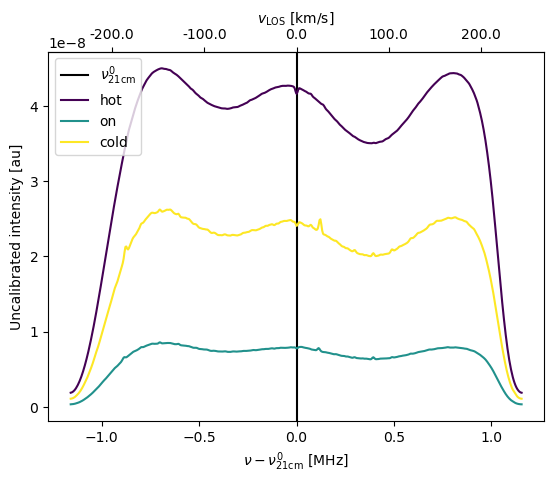

In [12]:
FOn = [fHot, fOn, fCold]
POn = [pHot, pOn, pCold]
Labels= ['hot', 'on', 'cold']

fig, ax, ax2 = d21.plot(FOn, POn, Labels)

Can a multiplicative factor get all the smooth baselines on top of each other?
I am rescaling hot and on to match cold, using the best fit linear amplitude.

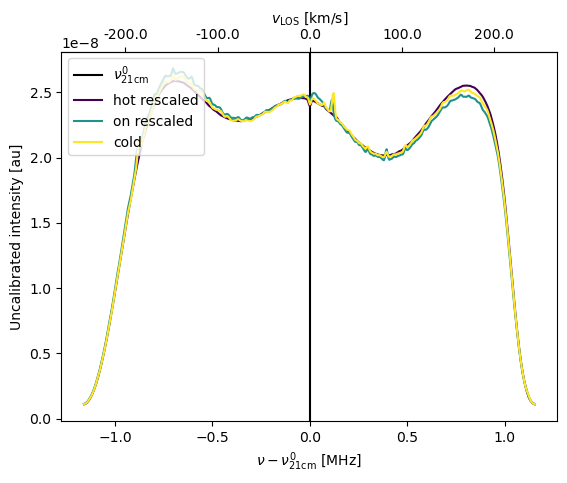

In [13]:
FOn = [fHot, fOn, fCold]
POn = [pHot * np.sum(pHot*pCold) / np.sum(pHot**2), 
       pOn * np.sum(pOn*pCold) / np.sum(pOn**2), 
       pCold]
Labels= ['hot rescaled', 'on rescaled', 'cold']

fig, ax, ax2 = d21.plot(FOn, POn, Labels)

Check how much the ratio varies.
After the rescaling, the ratio between on and cold appears to be a perfectly straight line.
We still have the issue of the RFI line in cold not present in on, but this would not affect the continua.

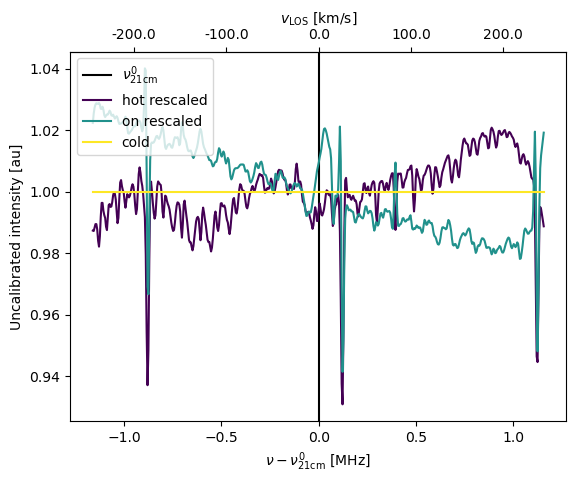

In [14]:
FOn = [fHot, fOn, fCold]
POn = [pHot / pCold * np.sum(pHot*pCold) / np.sum(pHot**2), 
       pOn / pCold * np.sum(pOn*pCold) / np.sum(pOn**2), 
       np.ones_like(pCold)]
Labels= ['hot rescaled', 'on rescaled', 'cold']

fig, ax, ax2 = d21.plot(FOn, POn, Labels)

# Everything below needs reformatting

In [15]:
FOn = np.array([expOnFile['fOn'] for expOnFile in expOnFiles])
POn = np.array([expOnFile['pOn'] for expOnFile in expOnFiles])

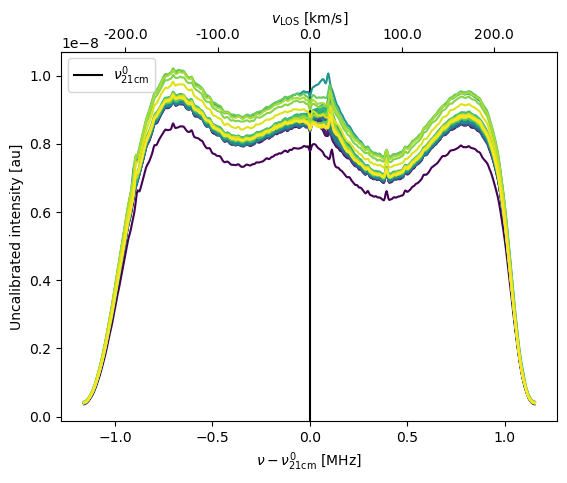

In [16]:
fig, ax, ax2 = d21.plot(FOn, POn)

Dividing all the on spectra by one of them (e.g., the first or last), it is striking to see that their continua only differ bya multiplicative factor.

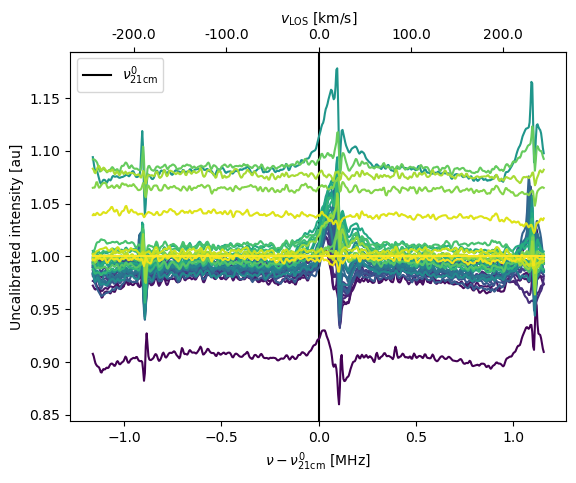

In [17]:
POnOverLast = POn / POn[-1, :]

fig, ax, ax2 = d21.plot(FOn, POnOverLast)

Rescaling for this amplitude, we get a constant continuum to subpercent over many hours!

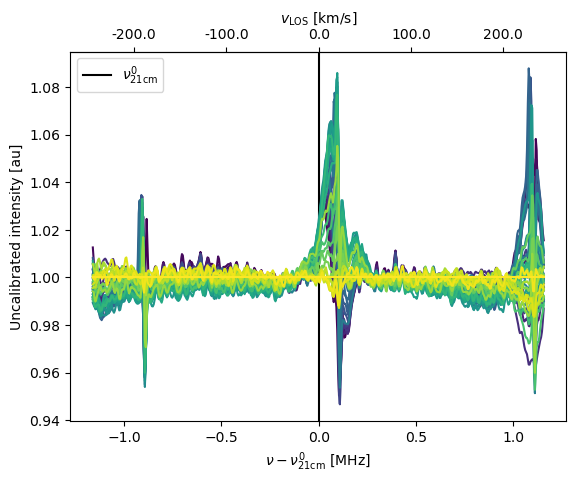

In [18]:
ref = POn[-1, :]  # reference row
dot_products = np.sum(POn * ref, axis=1)         # shape (N,)
row_norms_squared = np.sum(POn**2, axis=1)       # shape (N,)
scaling_factors = dot_products / row_norms_squared  # shape (N,)

POnOverLastRescaled = (POn / ref) * scaling_factors[:, None]

fig, ax, ax2 = d21.plot(FOn, POnOverLastRescaled)

Generate a gif to see the evolution

In [19]:
# Function to generate individual plots
def generate_plots(FOn, POn, output_dir="temp_plots"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # List to store file names of each generated plot
    plot_files = []
    
    # Loop through the data and create a plot for each element
    for i, (f, p) in enumerate(zip(FOn, POn)):
        fig, ax, ax2 = d21.plot(f, p)
        ax.set_title(f"Plot {i+1}")
        ax.set_ylim(0.94, 1.1)
        
        # Save the plot as an image
        plot_file = os.path.join(output_dir, f"plot_{i+1}.png")
        plt.savefig(plot_file)
        plot_files.append(plot_file)
        plt.close(fig)  # Close the figure to free up memory
    
    return plot_files

# Function to create a GIF from the saved plot images
def create_gif(plot_files, gif_name="output.gif", duration=0.5):
    with imageio.get_writer(gif_name, mode='I', duration=duration) as writer:
        for plot_file in plot_files:
            image = imageio.imread(plot_file)
            writer.append_data(image)
    
    # Optionally: Clean up the temporary images
#    for plot_file in plot_files:
#        os.remove(plot_file)


# Generate plots and create a GIF
plot_files = generate_plots(FOn, POnOverLastRescaled)
create_gif(plot_files, gif_name="output.gif", duration=0.5)

print("GIF created successfully!")

/tmp/ipykernel_7554/2841845822.py:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(plot_file)


GIF created successfully!
